<a href="https://colab.research.google.com/github/audrb1999/Paper_review/blob/main/03.Parallelism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Parallelism 에서 동기화
2. Data/Model Parallelism 에 대해서 더 알아보기
3. 통신 오버헤드를 줄이기위한 입출력 제한에 대해서 알아보기
4. PipeDream 이후 Parallelism 에 대해서 알아보기

- Gpipe 가중치 업데이트 방법과 pipedream 가중치 업데이트 방법의 차이

## Parallelism에서 동기화란?

일반적인 경우 대규모 딥러닝 모델의 학습을 가속할 경우 Data parallelism이나 Model parallelism을 사용하는데 이 두 방식의 구조에서 각 노드가 부분적인(Partial) 데이터 혹은 모델을 가지고 학습을 진행하기 때문에 일관성 있는 Global Parameter의 관리는 위해서는 각 노드로부터 계산된 중간 결과물 취합할 방법이 필요하다.



</br>

</br>

최근에는 Parameter server를 통한 Star Topology 방법을 대표적으로 사용하고 있는데 이 방법은 멀티 노드들이 parameter server에 Global parameter에 대한 조회 및 갱신 처리를 진행해야 하기 때문에 Global parameter 버전 관리를 위한 동기화 기법이 필요함

</br>


- 일관성 있는 global parameter를 위해서는 취합해서 관리할 필요가 있다.
- 이때 parameter server에서 관리를 하는데 global paramter 버전 관리를 위한 동기화 기법이 필요하다.


- 동기식 학습 방법은 빠른 Worker들이 느린 Worker들의 학습 속도에 맞추어 진행하여 Parameter server로부터는 항상 동일한 Global parameter를 동기화 받아 다음 학습 과정을 진행하는 방식 (PSGD)

- 비동기식은 worker들이 독립적으로 학습을 진행하여 동일하지 않은 Global Parameter를 동기화 받아서 다음 학습 과정을 진행하는 방식(PipeDream, Hogwild)

</br>


동기식의 경우 학습 정확도는 보장할 수 있지만 학습 속도를 보장할 수 없고 비동기식의 경우 학습 정확도를 보장할 수 없지만 학습 속도를 보장할 수 있다는 trade off가 발생

## Data Parallelism

각 디바이스가 다르분 부분 데이터를 같은 학습 모델로 이용하여 학습하도록 진행

</br>


- 손실함수 값을 최소화하는 것이 중요한데 이를 위해 데이터 병렬 처리에서는 데이터 일부를 이용하여 손실함수의 경사도를 구하는 SGD를 사용

- 데이터 양은 늘어나는데 처리하는 용량이나 네트워크 대역폭은 여전히 부족함, 그래서 확률적 경사하강법보다 더 효율적인 분산형 데이터 분석 알고리즘이 더 필요하다고 생각하여
  - PSGD[12]에서는 병렬식 확률적 경사하강법(Parallel Stochastic Gradient Descent)을 제안하였다
  - 각 프로세서 에서 수행한 SGD 결과를 마스터 루틴에서 취합하여 평균을 구하는 방식
  - PSGD는 각 프로세서에서 매개변수의 로컬 사본에서 SGD를 실행한 후 마스터 루틴으로 솔루션을 집계

> SGD가 데이터를 대표하지 못한다는 문제도 해결
  

또한 모든 프로세서가 작업을 끝내야만 다음 epoch으로 갈 수 있다. 이로인해 메모리 록킹(Memory Locking) 문제가 발생, 효율적인 메모리 사용이나 동기화가 어렵다.

- 전체 기울기 결과를 마스터 루틴에서 종합하여 평균을 내야하기 때문에 모든 디바이스들이 작업을 완료해야함

**PSGD**
- 각 프로세서는 매개변수의 로컬 사본에서 SGD를 실행한 다음 마스터 루틴으로 솔루션을 집계합니다.
  - 기존 SGD는 빠르지만 데이터 집합의 대표성을 가지지 못한다는 단점이 있어서 수렴이 어려웠음, 여기서는 그걸 해결하고자 각 배치들의 SGD를 평균내어 진행한 느낌
  - 모든 proecssor가 작업이 끝나기 전까지 다음 epoch을 진행하지 못한다는 단점이 존재
  
</br>

**Hogwild**
- 메모리 잠금 및 동기화로 인한 성능 저하 문제 해결 목적
- 프로세서들이 공유 메모리에 엑세스하고 메모리의 개별 구성 요소를 동시에 업데이트하는 방법
  - gradient descent를 진행할 때 최신 상태를 반영하지 않기 때문에 스레드가 동시에 업데이트를 진행할 수 있다.
  - PSGD의 메모리 록킹 문제를 해결할 수 있지만 데이터가 희소한 경우에만 적절한 알고리즘
  
</br>

**MALT**
- 기존 프레임워크의 장기 학습 작업을 가능하는 목적을 가짐
- 유연한 AP를 가진 데이터 병렬 간단한 기계 학습 프레임워크 제공

</br>




</br>
</br>

## Model Parallelism

</br>

독립된 디바이스들에게 여러 개의 부분 모델로 분할하여 할당해, 동일한 학습 데이터 배치들을 사용해 순차적으로 학습을 진행하였다.

모델 병렬 처리
- 학습 모델을 분할하여 디바이스가 모델의 일부분을 가지고 학습을 진행하는 방법이다

- 딥러닝 모델의 연산을 여러디바이스들에게나누어 진행함으로써 엣지 디바이스의제한된저장공간의특성을 극복할 뿐만 아니라 연산오버헤드(Overhead)또한 감소시킬 수 있다.

### Megatron-LM

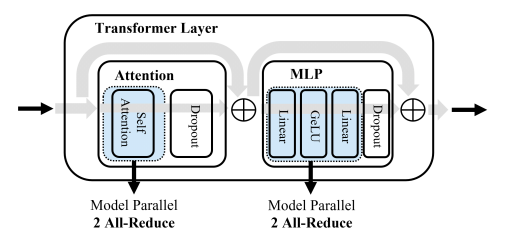

- 거대한 transformer 모델을 효과적으로 학습하기 위해 intra layer model parallelism을 이용한 방법

- 다층 퍼셉트론 블록은 결과 출력 간의 동기화 지점을 제거하여 통신을 요구하지 않고 직접 출력을 가져옴

- self attention block의 경우 행렬을 키, 쿼리, 값으로 분할하여 각 GPU에서 지역적으로(Locally) 처리하는 병렬 방식

- 위 사진과 같이 총 4개의 통신 오퍼레이션이 있는 forward pass, backward pass 전달 경로에서 두 개의 축소(All-Reduce)된 오퍼레이션만 사용하는 것이 가능함 = 이게 입출력 제한인가?

- 통신 오버페드를 줄이며 GPU가 처리한 결과의 복사본을 사용해 파라미터를 정규화하여 추가적인 오류를 방지하기 때문에 대규모 모델을 학습할 수 있다.

- 새로운 컴파일러나 라이브러리 없이 쉽게 구현이 가능하다는 장점도 존재

단점

- 하지만 아직 optimizer의 효율성과 메모리 풋 프린트를 개선할 필요가 있다는 한계가 존재

</br>

</br>


3D parallelism

기계 번역 정확도를 높이고자 전통적으로 Encoder - Decoder 방식을 사용했지만 인코더는 신경망 네트워크가 source 문장으로부터 모든 정보를 고정된 길이의 벡터로 압축하기 때문에 bottleneck 현상이 발생될 수 있다.

- 이러한 문제점을 해결하기 위한 방식이 GNMT


</br>

모델 파라미터를 스케줄링하는 프로그래밍 가능한 모델 병렬 처리시스템으로 학습을 빠르게 수렴하기 위해 어떤 파라미터들에 집중해 업데이트할지 우선순위를 정한다.

- STRADS 방식, 경량화 방식 중 prunning의 경우 모델의 가중치 중 일부 중요한 구조만 남겨두고 나머지는 0으로 만드는 기법이 존재, 이 방식에서도 중요한 구조의 가중치만 학습시키는 방법을 사용하는 것 같다.

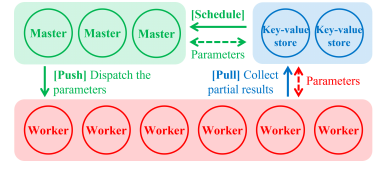

- STRADS의 시스템 인터페이스 구조

### PipeDream 이후 논문


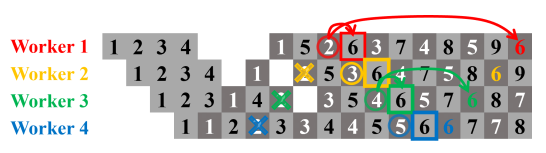

기존 pipedream의 경우 forward pass를 진행할 때는 최신 파라미터를 사용하지만 backward pass를 진행할 시점에서는 훨씬 이전의 파라미터이기 때문에 가중치 스케일니스 문제가 발생했었음

- 이러한 문제를 해결하고자 나온 것이 SpecTrain




last parameter가 어떤 기준인지, 이걸 사용했을 때 이점이 무엇인지 알아보기



> 연한 회색: forward pass

> 진한 회색: backward pass

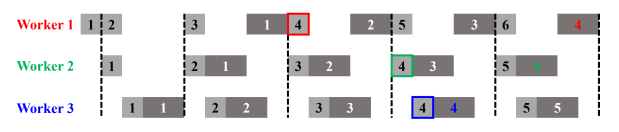

pipedream의 실제 기반 파라미터

- 4번으로 forward pass한 값을 기반으로 backward pass에서 업데이트할 경사도를 계산

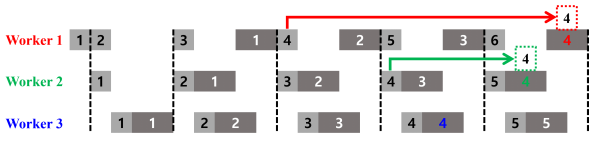

SpecTrain의 예측 기반 파라미터

- 현재 알고 있는 파라미터(4번)을 기반으로 backward pass가 진행될 때의 파라미터를 예측한다.

- 4번 backward pass를 할 때 4번 forward pass의 파라미터를 예측해서 진행
 - 기존에 메모리에 가중치를 저장하는 방식은 모델이 커질수록 메모리 용량을 잡아먹었지만 여기선 그런 문제는 없음

- 본 survey 논문에서 예측을 통한 작업 대부분에서 정확도 감소가 없었다고 한다.

SpecTrain의 경우 backward pss를 진행할 때 예측한 파라미터 값을 사용한다.

미니배치 - 마이크로 배치 (x)

pipedream - gpipe 가중치 동기화 방법의 차이
- pipedream 단점 장점, gpipe 단점 장점(x)
- deepspeed에서는 어떤 방법을 사용하는지()

- pipeline mismatch 해결 방법 (ㅌ)

- 가중치 스태싱이란?()

> pipedream 이후

## minibatch에 대해서 알아보자

그러기 위해서 GPipe에 대해서 알아볼 예정

- Pipeline model parallelism과 Re-materialization에 대해서 알아보자
- 이 내용을 바탕으로 구현한 GPipe에 실험적인 결과를 통한 성능 및 최적화 방법에 대해서 알아볼 예정

Gpipe는 구글 AI team에서 2018년도에 출제한 논문, GPipe가 특정 논문은 아니고 오픈 소스 라이브러리의 이름임

- 텐서플로우의 lingvo에 구현이 되어 있다.

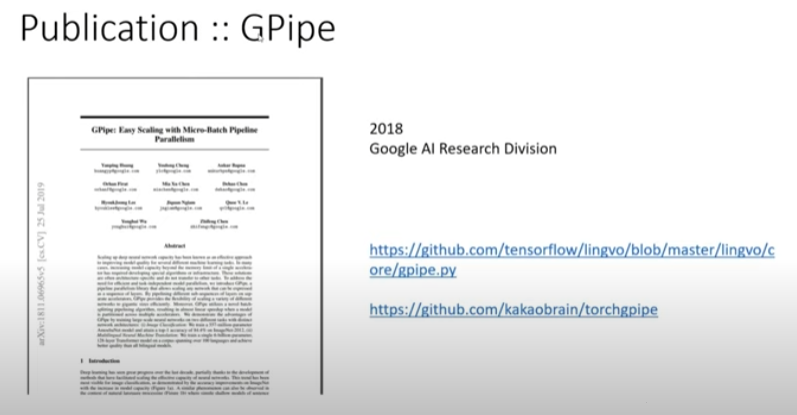

파이토치에서는 카카오브레인에서 개발한 torchgpipe가 있습니다.

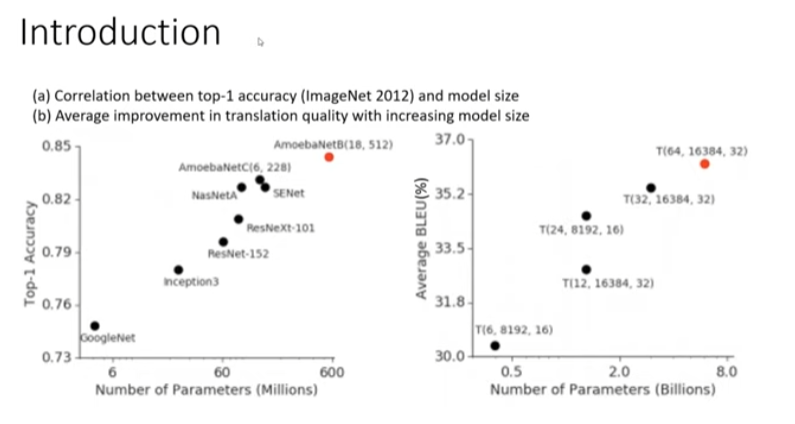

G파이프가 만들어진 목적

- 딥러닝과 하드웨어 스팩의 발전에 따라 모델의 크기도 점점 커지고 있음
- 성립되지 않을 때도 있지만 대부분 모델의 크기가 클 수록 더 좋은 정확도를 가짐(위 사진을 통해 확인할 수 있다.)
  - 첫 번째 그래프는 파라미터 양에 따른 이미지넷 정확도를 보여줌
  - 두 번째 그래프는 파라미터 양에 따른 Transformer의 quality  점수를 나타낸 것(번역의 품질)
    - 젤 왼쪽의 숫자가 인코더와 디코더의 레이어 개수, 그 뒤의 숫자가 dimention을 의미

두 그래프 다 모델의 크기가 클수록 전반적으로 좋은 정확도를 내는 것을 알게 해줌

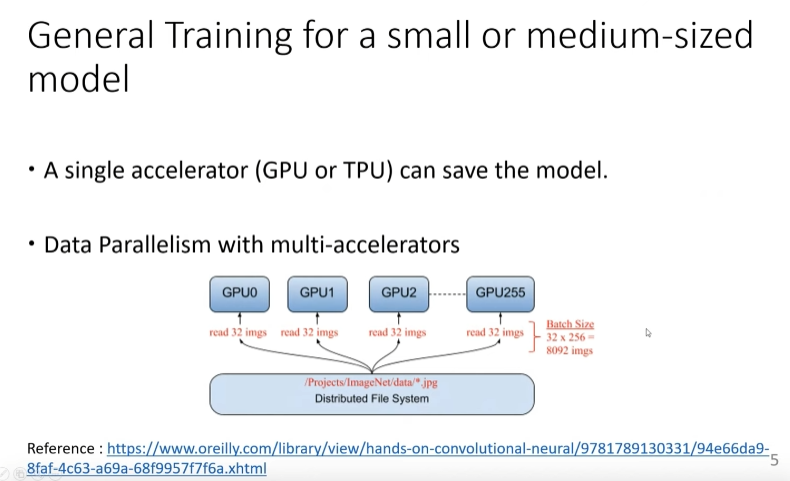

이러한 큰 모델을 학습하는 것은 적당한 사이즈의 모델을 학습하는 것과 차이점이 있음

- 적당한 사이즈의 모델은 일반적으로 한 개의 디바이스에 들어갈 수 있을 만한 메모리를 사용함
  - 따라서 여러 개의 디바이스를 사용하는 경우 각각의 디바이스에 모델을 load하고 데이터를 분산시켜 학습하는 Data 병렬 처리를 사용함

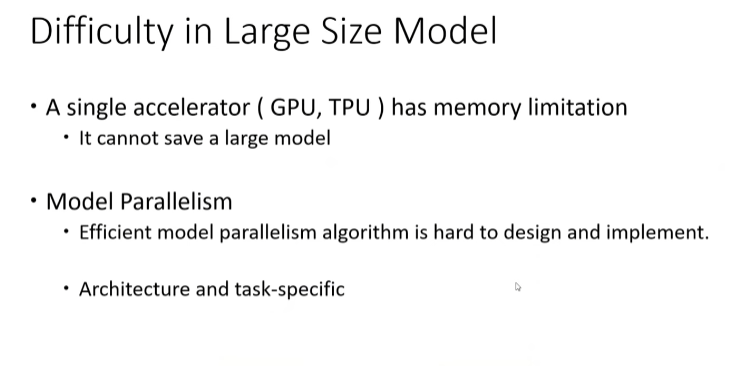

하지만 큰 모델의 경우 하나의 디바이스에 다 들어가지 못할 정도의 메모리를 사용함

- 이를 해결하기 위해서는 모델 병렬 처리가 필요함
- 하나의 디바이스가 모델을 로드하는 것이 아닌 각각의 디바이스가 모델의 일부분을 로드하도록 하는 것

이러한 모델 병렬처리는 효율적으로 알고리즘을 구현하기가 어려움, 효율적인 모델 알고리즘들은 대게 특정 아키텍처나 task에 종속이 됨
  - 즉 전반적인 모델에 활용하기 어렵고 전반적인 task에 활용하기도 어렵다 특정 모델이나 특정 task에서만 활용가능!
  - 모든 모델을 효율적으로 나누기 힘드는 한 모델의 아키텍처에 종속되는 것

본 논문에서 제안하는 GPipe는 이러한 모델 병렬 처리를 극복하는 라이브러리

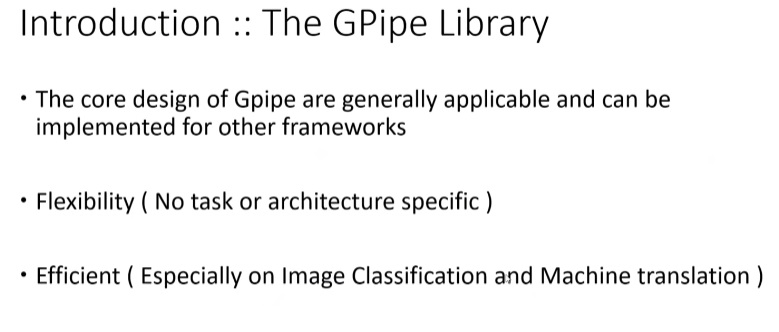

Gpipe의 핵심적인 알고리즘은 모두 다른 프레임 워크에서 구현될 수 있다.

이전의 문제점이였던 특정 task나 모델의 architecture에 종속이 되지도 않고 이미지 분류나 기계 번역에서 좋은 성능을 보여줌

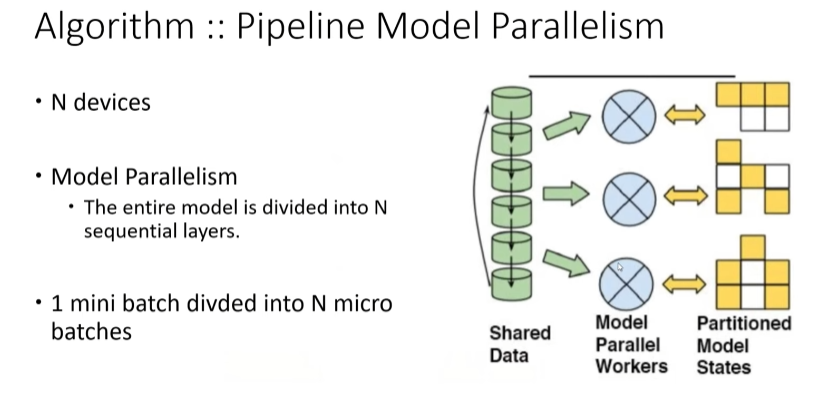

Gpipe의 핵심적인 알고리즘 2개를 살펴보자

- 파이프라인 모델 병렬처리

기존의 모델 병렬 처리의 경우 큰 모델을 n개의 partition(분할)으로 나누어 1개의 partition(분할)이 하나의 sequential layer가 됩니다.
  - 즉 이렇게 나눈 것들 2개를 1하나의 GPU에 넣음

- 이렇게 되면 한 디바이스에서 연산을 하고 있으면 다른 디바이스에서는 연산을 하지 못하는 문제점이 발생합니다.

이게 원래 모델 병렬 처리의 문제점

파이프라이닝 기법도 이렇게 분리하지만 다른 점으로 1개의 미니 배치를 n개의 마이크로 배치로 나누어서 파이프라인을 진행하기에 이러한 문제점을 보완할 수 있다.

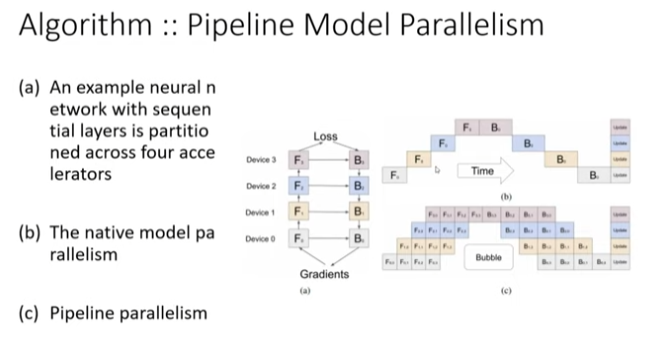

여기서 4개의 디바이스를 사용해서 모델 페럴리즘을 할 때 디바이스를 나타냄

- 전체 모델을 4개의 partition으로 나누었고 각각 디바이스에 로드가 되어있음

- 기존에 미니배치는 여러 디바이스를 쓰고있음에도 불구하고 앞에 작업이 끝나기 전까지 동작하지 않음

- 반면에 아래 마이크로 배치의 경우 마이크로 배치만을 계산하고 다음 디바이스로 넘김으로서 여러 개의 디바이스르 더 효율적으로 사용할 수 있따.

- 그럼 어떻게 마이크로 배치를 나눌 것인가?

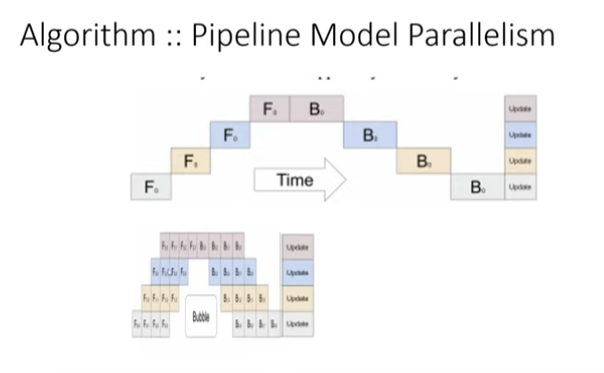

실제로 비교해보자면 다음과 같이 확실히 시간이 줄어든 것을 확인할 수 있따.

- 대기 시간이 짧아짐

- 그림에서는 반 정도 줄어든 것 같지만 디바이스간에 오버헤드가 존재하기 떄문에 이것보다 조금 더 걸림

- 일반적인 프로세서에서 사용하는 파이프라인들은 해저드가 발생했엇음 = 그 이유는 그런 문제가 존재하는 데이터를 사용했기 때문이고 여기서는 해저드가 있을 수 있는 것이 batch normalizaiton 정도

- 논문에서 소개가 되어있지는 않음

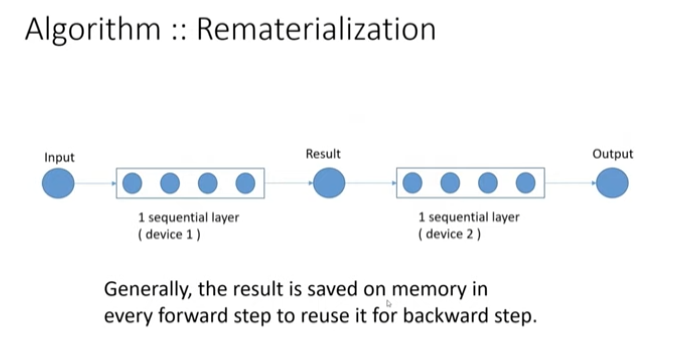

메모리 효율을 높이기 위한 방법중 하나

- 일반적으로 딥러닝 프레임워크들이 forward pass때 layer의 입력값을 저장하고 있음, layer의 입력값을 backward pass 때 경사하강법으로 사용할려고

- 위 그림은 한 개의 모델을 2개의 파티션으로 나눈 예제, 1개의 레이어가 1개의 시퀀셜 레이어를 담당함

- rematerialization이 없이 모델을 학습한다면 forward pass 때 모든 레이어의 입력값들을 저장하고 있음

- 최종으로 봤을 때 위에서 8개의 입력값을 저장함, result 양옆에 각 4개의 레이어가 존재

이 방법은 sequentional layer의 입력값만 저장하고 그 내부의 입력값은 저장하지 않음

- 즉 시퀀셜 레이어에 있는 4개의 레이어들은 무시하고 통째로 본다는 것 여기서는 2개의 시퀀셜 레이어가 존재하니 2개의 입력값만 저장
  - 메모리를 많이 아낄 수 있음

- 이게 forward pass 과정이고 backward pass 때는 다시 1나의 시퀀셜 레이어에 대해서 안쪽 레이어에 대해서 입력값을 저장함
  - 그 다음 forward pass를 다시 타게해서 다시 계산해서 입력값들을 구하고 그를 바탕으로 기울기를 계산

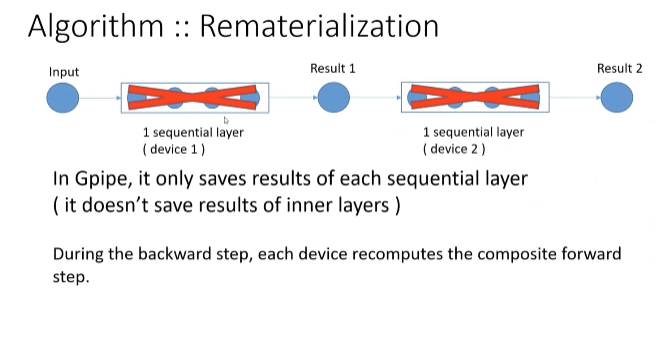

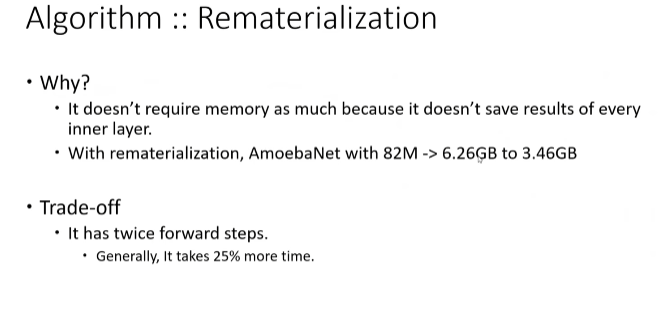

실제 적용 결과 6.26기가 차지하던게 3.46기가로 줄음

- 어느정도의 trade off 관계가 발생하는데 trade off 관계가 존재함, forward 구간이 한번 더 늘어남, backward때 알아야하니까

- 그래서 대략 25%의 시간이 더든다

- 그러니까 전체를 저장하면 좋지 않으니 각 시퀀셜 레이어의 입력값만 저장하다가 backward pass할 때 값이 필요하면 저장했던 입력값으로 forward pass를 돌린 다음 그 결과물로 업데이트 한다는 느낌?



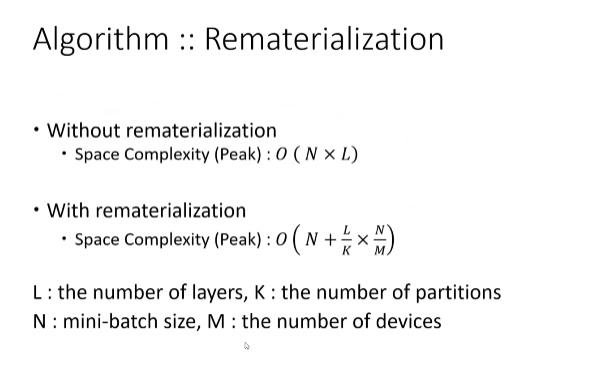

다음과 같은 시간 복잡도를 가짐

- 메모리를 많이 줄임

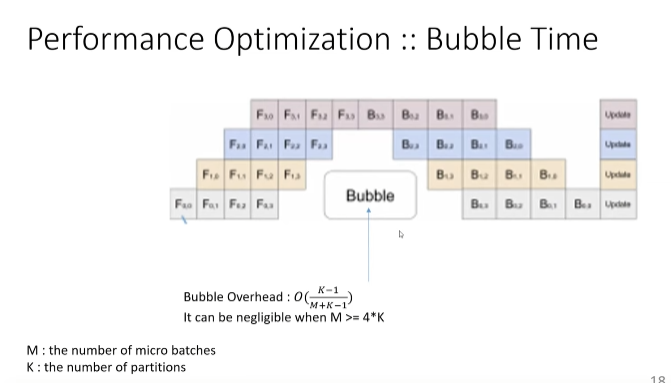

파이프라인 모델 페럴리즘을 진행했을 때도 버블 타임이 존재

이 버블시간은 partition의 수(k), 마이크로 배치 수(m)에 따라 위와 같은 시간 복잡도를 가짐

- m이 k의 4배 정도일때 버블 타임을 거의 무시할 수 있을 정도가 된다고 논문에서 알아냄

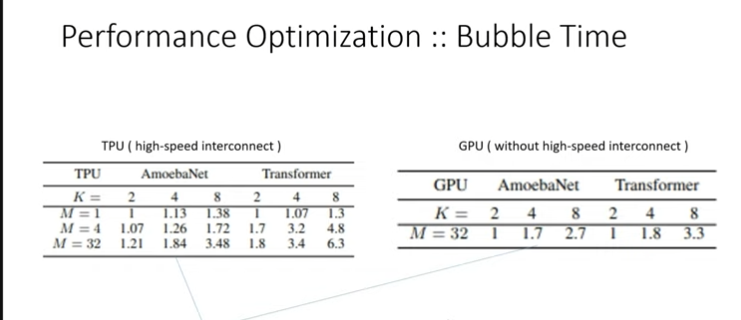

Amebanet 같은 경우 partition을 8개로, 마이크로 배치 수를 32개로 했을 때 거의 3.5배 에 해당하는 속도를 가지고 있다.

transformer의 경우 6배에 달하는 속도를 가짐

- 여기서 아메바 넷의 속도 증가가 트랜스포머 보다 낮은 이유는 아메바 넷의 레이어들이 트랜스포머와 비교했을 때 imbalance하기 때문

- 각각의 디바이스들이 다른 연산량을 가짐

TPU와 GPU표를 봐보면 TPU가 상대적으로 빠른 것을 알 수 있음

- TPU는 빠른 전송속도를 제공하기 때문에 GPU보다 빠름(디바이스들 간의 데이터 전송속도가 빠름 = 오버헤드가 적음)

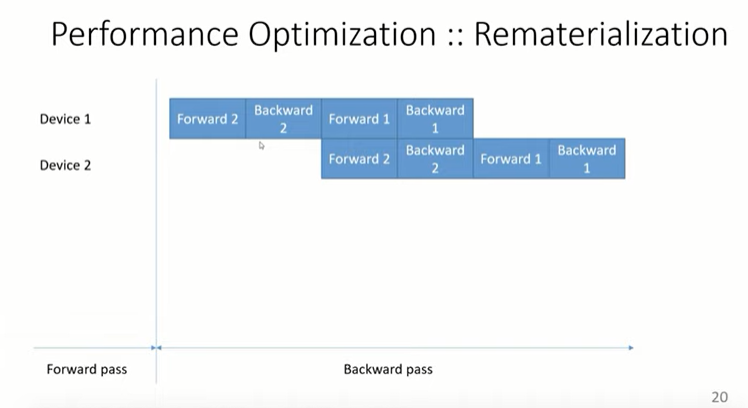

rematerialization의 경우도 최적화가 가능함

- 스케쥴링을 조금 더 앞당겨선

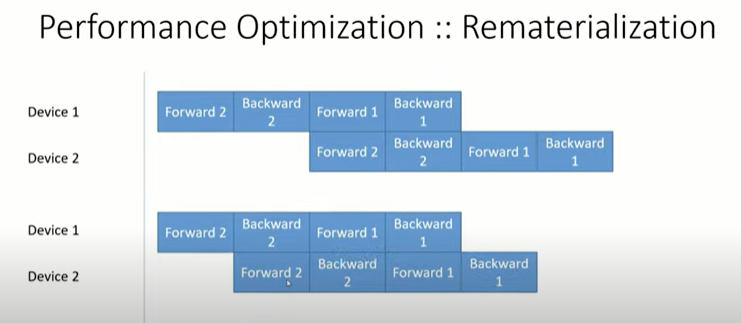

이렇게 미리 계산을 함으로써 시간을 줄임

- 많은 디바이스를 사용하는 경우 꽤 큰 시간을 줄일 수 있음

Gpipe로 얼마나 큰 모델을 학 습할 수 있을까?

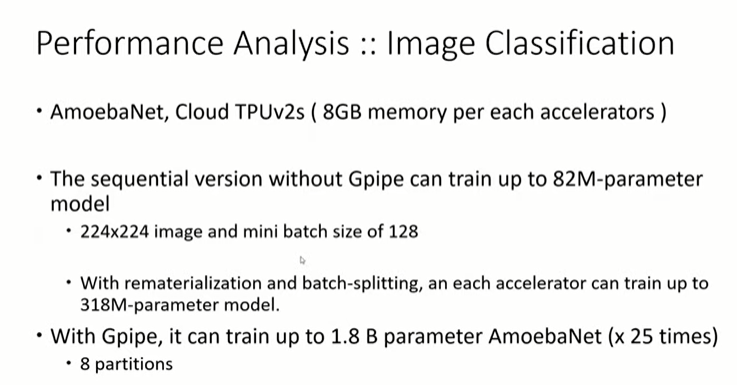

아메바넷을 기반으로 실험했고

클라우드 tpu버전 2를 사용

- 각 디바이스당 8기가 바이트의 메모리를 가짐, 이는 한 디바이스 당 82M 파라미터 모델까지 훈련이 가능

- 여기서 rematerialization과 batch-splitting 을 이용하면 318M까지 가능

논문에ㅓ는 8개의 디바이스를 활용해서 1
8억 파라미터 아메바넷을 훈련

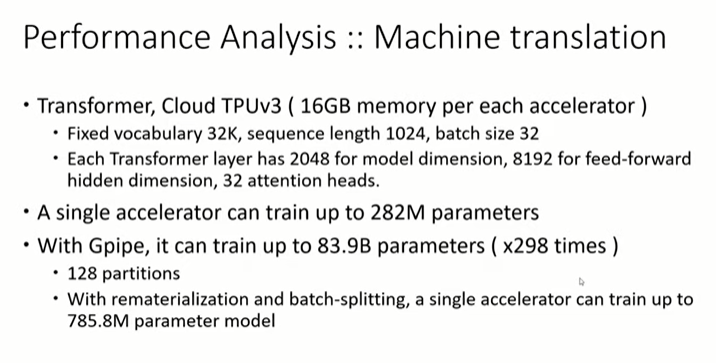

파티션이 128개이니 128 디바이스에서 학습한 것

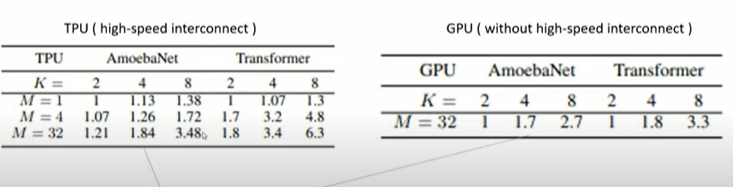

마이크로 배치로 인해 속도 향상으로 시간이 줄어듬 = 마이크로 배치를 사용하는 이유

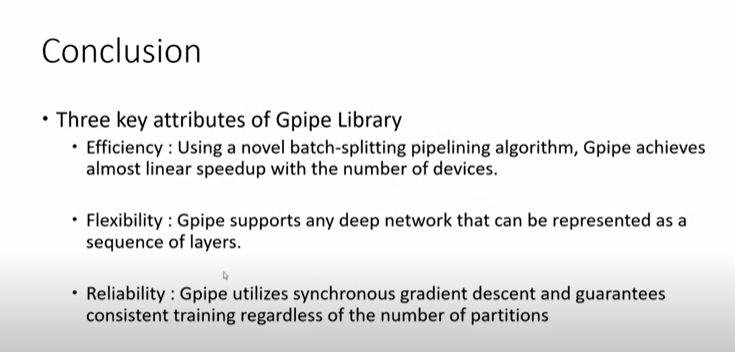

## Gpipe 장단점

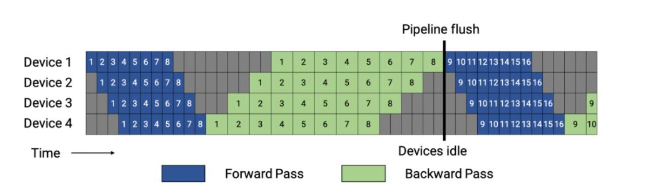

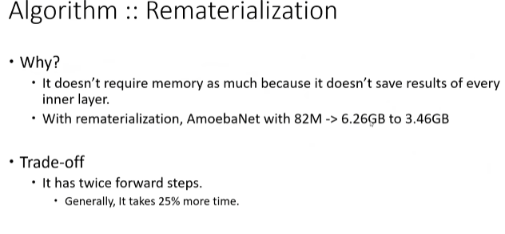

***장점***
- GPipe는 여러 개의 배치를동시에처리하는것이 아니라 하나의 배치를 분할하여 오버랩(Overlap)하는 방식이다. (mini-batch를 micro batch로 쪼개어 walker가 활성화되지 않는 상황을 줄임)
- Rematerialization: 모든 중간 출력값들을 가지고 있으면 메모리에 부담이 크기 때문에 Sequential layer의 입력값만 저장하고 backward pass 과정에서 입력값을 통해 forward pass를 진행해서 기울기를 구함
  - 실제 모델에서 6.26GB 메모리를 차지하는 것을 3.46GB로 줄임


***단점***
- backward pass 과정에서 forward pass를 한번 더 진행하여 값을 25%의 시간이 더 걸리게 됨

- 정확한 모델 분할과 task 사이의 균형 없이는 속도 증진을 얻기 힘듬

- 하나의 배치를 처리한 후 각 디바이스가 파라미터를 갱신한 다음 배치가 진행되기 때문에 마이크로 배치를 사용함에도 여전히 디바이스가 가동되지 않는 시간이 존재.


> Gpipe는 단일 가중치 버전을 사용함
> 주기적인 파이프라인 flush를 도입하여 메모리 공간을 줄일 수 있음(이 과정을 진행하여 처리량 감소)

> 파이프 드림은 이게 없어서 처리량 증가하지만 파이프라인 깊이에 따른 버전들을 관리해야하므로 메모리 사용량 증가

그래서 파이프라인 깊이에 따라서 선형적으로 증가하는 가중치 버전대신에 두 가지 가중치 버전만 유지하기로 함

- 쉐도우 버전과 메인 버전








## PipeDream 장단점

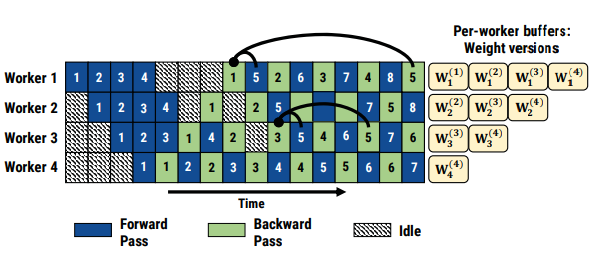

mismatch

- worker 1을 보면 미니배치 1로 부터의 업데이트를 적용하고 미니배치 5에 대한 forward pass를 진행 미니배치 5 backward pass는 2, 3, 4 미니 배치 백워드 패스가 적용된 가중치로 진행

- 이러한 가중치 불일치는 잘못된 기울기를 초래하고 모델 수렴을 막음

- 가중치 스태싱을 통해서 각 활성 미니배ㅣ에 대해 하나씩 가중치의 여러 버전을 유지, 위 그림에서 알 수 있듯이 주어진 미니배치의 순방향전달과 역방향 전달에 동일한 매개 변수를 사용

각 미니 배치마다 여러 버전의 가중치를 유지, 각 파이프 라인 단계에서 forward pass에서 사용 가능한 최신 버전의 weight를 사용하여 미니 배치를 처리

전진 패스에서 사용 가능한 최신 버전의 weight를 사용하여 미니 배치를 처리 후 이것을 저장 그런 다음 동일한 무게 버전을 사용하여 미니 배치의 역방향 패스에서 무게 업데이트 및 upstream 가중치 기울기를 계산



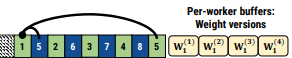

미니배치 1에 대해서 업데이트가 적용된 후 미니 배치 5에 대해서 forward pass를 진행 이후 2, 3, 4 미니 배치에 대해서 업데이트가 되고 5 backward pass를 진행

이러면 미니배치 5에 대해서 forwad pass때와 backward pass 때 사용한 가중치 버전이 불일치하다고 할 수 있다!

가중치 스태싱은 단계 내에 동일한 버전의 모델 가중치가 미니 배치의 backward pass와 forward pass 경로에 사용되도록 보장함

mismatch 해결

- 수직동기화(vertical sync)

여러 단계에 걸쳐 잠재적 불일치를 제거

파이프라인에 들어가는 각 미니 배치$b_{(i)}$를 입력 단게에서 표시된 최신 가중치 버전 $w_{(i-1)}$와 연결해줌


bi에 대해 역방향 패스를 수행한 후(스테이징된 가중치 w(i-x)) 각 단계는 독립적으로 가중치 업데이트를 적용하여 최신 가중치(w(i)를 생성한 다음 w(i-x)를 삭제할 수 있습니다

- 이 과정은 독립적(비동기)